In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
import random as rd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Tic-tac-toe with Reinforcement Learning

This notebook aims to implement a reinforcement learning agent to play the game of tic-tac-toe. The agent will be trained with the usual value-state algorightm, and will be tested against a random player and an optimized player. After training, the agent will be able to play against a human player.

## Notebook Overview:

1. [Modeling](#Modelig)
2. [Training](#Training)

# Modeling
## Game description
Tic-tac-toe is played on a $3\times 3$ board. The first player (represented by X) chooses a square to put one of their symbols. The second is represented by O, and they alternate in turns putting their respective symbols on unoccupied squares. The first player to get three of their symbols in a row (horizontally, vertically or diagonally) wins the game. If all squares are occupied and neither player has three in a row, the game ends in a draw.

## Description of the states
As each possible board is a collection of 9 squares, each of which can be occupied by one of three symbols (X, O or empty), there are $3^9 = 19683$ possible states. Therefore, we can represent each possible state as a number between 0 and 19682.

In [35]:
MAX_STATES = 19683

# Função que retorna o estado do jogo
def get_state(board):
    state = 0
    for i in range(9):
        if board[i] == 'X':
            state += 3**i
        elif board[i] == 'O':
            state += 2*(3**i)
    return state

# Função que mostra o tabuleiro
def print_board(board):
    for i in range(9):
        if i % 3 == 0 and i != 0:
            print()
        if i % 3 != 2:
            print(board[i], end = '|')
        else:
            print(board[i], end = ' ')
    print()

# Função que retorna o tabuleiro a partir do estado
def get_board(state):
    board = [' ' for i in range(9)]
    for i in range(9):
        if state % 3 == 1:
            board[i] = 'X'
        elif state % 3 == 2:
            board[i] = 'O'
        state = state // 3
    return board

Let's test these functions:

In [36]:
board = [' ', ' ', 'X', ' ', 'O', ' ', 'X', ' ', ' ']
print(board)
print(get_state(board))
print(get_board(get_state(board)))
print_board(board)

[' ', ' ', 'X', ' ', 'O', ' ', 'X', ' ', ' ']
900
[' ', ' ', 'X', ' ', 'O', ' ', 'X', ' ', ' ']
 | |X 
 |O|  
X| |  


We can also define a function that checks if a given state is a terminal state (i.e. if the game is over). This function will return the symbol of the winner if there is one, or ```'draw'``` if the game is a draw, or ```' '``` if it is not over yet.

In [37]:
# Função que checa se algum jogador ganhou
def check_win(board):
    for i in range(3):
        if board[i] == board[i+3] == board[i+6] != ' ':
            return board[i]
        if board[3*i] == board[3*i+1] == board[3*i+2] != ' ':
            return board[3*i]
    if board[0] == board[4] == board[8] != ' ':
        return board[0]
    if board[2] == board[4] == board[6] != ' ':
        return board[2]
    if ' ' not in board:
        return 'draw'
    return ' '

# Training
## Training the agent
To train the agent, we will use the value-state algorithm. This algorithm consists of initializing the value of each state to $0.5$ (or $0$ if it's a losing board, or $1$ if it's a winning board), and then playing many games against a random player (a smarter player is also used sometimes). After each game, the value of each state visited by the agent is updated according to the following rule:
$$V(S_t)=V(S_t)+\alpha(V(S_{t+1})-V(S_t)),$$
where $\alpha$ is the learning rate.

First, we'll define a function that returns the move according to the opponent's strategy.

In [101]:
# Função que treina o computador jogando
def train_play(player_symbol, state, archetype):
    board = get_board(state)
    while True:
        pos = rd.randint(0, 8)
        if board[pos] == ' ':
            break
    if archetype == 'random':
        return pos
    opponent = 'X' if player_symbol == 'O' else 'O'
    for i in range(9):
        if board[i] == ' ':
            board[i] = opponent
            if check_win(board) == opponent:
                pos = i
                break
            board[i] = ' '
    for i in range(9):
        if board[i] == ' ':
            board[i] = player_symbol
            if check_win(board) == player_symbol:
                pos = i
                break
            board[i] = ' '
    if archetype == 'kinda smart':
        return pos
    return pos

Now we train the agent by playing various games against a player. Our main goal is to update the value of each state visited by the agent.

In [102]:
# Função que retorna "aproveitamento" do player
def get_score(player_symbol, values, epochs):
    wins_for_the_computer = 0
    draws = 0
    for _ in range(epochs):
        board = [' ' for i in range(9)]
        state = get_state(board)
        opponent = 'X' if player_symbol == 'O' else 'O'
        for turn in range(9):
            if check_win(board) != ' ':
                break
            if (turn % 2 == 0 and player_symbol == 'X') or (turn % 2 == 1 and player_symbol == 'O'):
                max_value = -1
                for i in range(9):
                    if board[i] == ' ':
                        board[i] = player_symbol
                        new_state = get_state(board)
                        board[i] = ' '
                        if values[new_state] > max_value:
                            max_value = values[new_state]
                            pos = i
                board[pos] = player_symbol
            else:
                pos = train_play(player_symbol, state, 'kinda_smart')
                board[pos] = opponent
            new_state = get_state(board)
            state = new_state
        if check_win(board) == player_symbol:
            wins_for_the_computer += 1
        elif check_win(board) == 'draw':
            draws += 1
    return (wins_for_the_computer+0.5*draws)/epochs

# Função que aprende a jogar
def learn(player_symbol, learning_rate, exploration_rate, epochs):
    values = [0.5 for i in range(MAX_STATES)]
    for i in range(MAX_STATES):
        board = get_board(i)
        if check_win(board) == player_symbol:
            values[i] = 1
        elif check_win(board) == 'draw':
            values[i] = 0.5
        elif check_win(board) != ' ':
            values[i] = 0

    archetypes = ['random', 'kinda_smart']
    evolution_history = []

    for epoch in range(epochs):
        archetype = rd.choice(archetypes)
        board = [' ' for i in range(9)]
        state = get_state(board)
        opponent = 'X' if player_symbol == 'O' else 'O'
        for turn in range(9):
            if check_win(board) != ' ':
                break
            if (turn % 2 == 0 and player_symbol == 'X') or (turn % 2 == 1 and player_symbol == 'O'):
                explore_flag = False
                if rd.random() < exploration_rate:
                    explore_flag = True
                    while True:
                        pos = rd.randint(0, 8)
                        if board[pos] == ' ':
                            break
                else:
                    max_value = -1
                    for i in range(9):
                        if board[i] == ' ':
                            board[i] = player_symbol
                            new_state = get_state(board)
                            board[i] = ' '
                            if values[new_state] > max_value:
                                max_value = values[new_state]
                                pos = i
                board[pos] = player_symbol
                new_state = get_state(board)
                if not explore_flag:
                    values[state] += (learning_rate ** (turn + 1)) * (values[new_state] - values[state])
            else:
                pos = train_play(player_symbol, state, archetype)
                board[pos] = opponent
                new_state = get_state(board)
                if archetype != 'random':
                    values[state] += (learning_rate ** (turn + 1)) * (values[new_state] - values[state])
            state = new_state
        if epoch % 1000 == 0:
            print('Epoch:', epoch)
        if epoch % 100 == 0:
            evolution_history.append([epoch, get_score(player_symbol, values, 200)])
    return values, np.array(evolution_history)

We can also visualize it learning:

In [103]:
# Função que printa o gráfico de evolução
def plot_evolution(evolution_history):
    plt.figure(figsize=(10, 6))
    plt.plot(evolution_history[:, 0], evolution_history[:, 1], "-o", label="train")
    plt.xlabel('Epochs')
    plt.ylabel('Win Rate')
    plt.title('Evolução do Aproveitamento')
    plt.show()

## Hyperparameter tuning
Let's try to find the best hyperparameters for our agent. We'll try different values for the learning rate and the exploration rate.

In [104]:
possibilities = [i/10 for i in range(2, 10, 2)]

configurations = []

for learning_rate in possibilities:
    row = []
    for exploration_rate in possibilities:
        values, evolution_history = learn('O', learning_rate, exploration_rate, 2000)
        score = get_score('O', values, 500)
        values, evolution_history = learn('X', learning_rate, exploration_rate, 2000)
        score += get_score('X', values, 500)
        row.append(score/2)
    configurations.append(np.array(row))

configurations = np.array(configurations)

Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000
Epoch: 0
Epoch: 1000


And then we can visualize it in heatmaps.

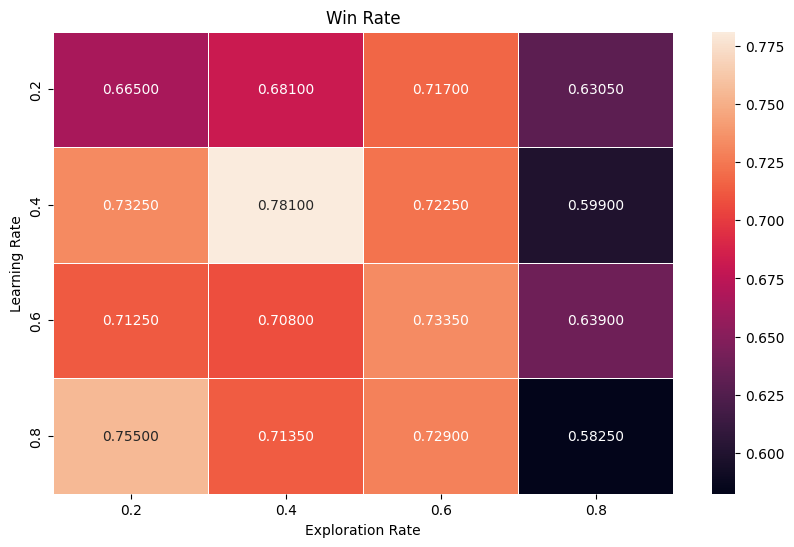

In [105]:
fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(configurations, annot=True, xticklabels=possibilities, yticklabels=possibilities,
                    fmt='.5f', linewidth=.5)
ax.set(xlabel="Exploration Rate", ylabel="Learning Rate", title="Win Rate")
plt.show()

And so we found out that the best configurations are with low rates. Let's train the agent with parameters along these lines.

Epoch: 0
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000
Epoch: 6000
Epoch: 7000
Epoch: 8000
Epoch: 9000


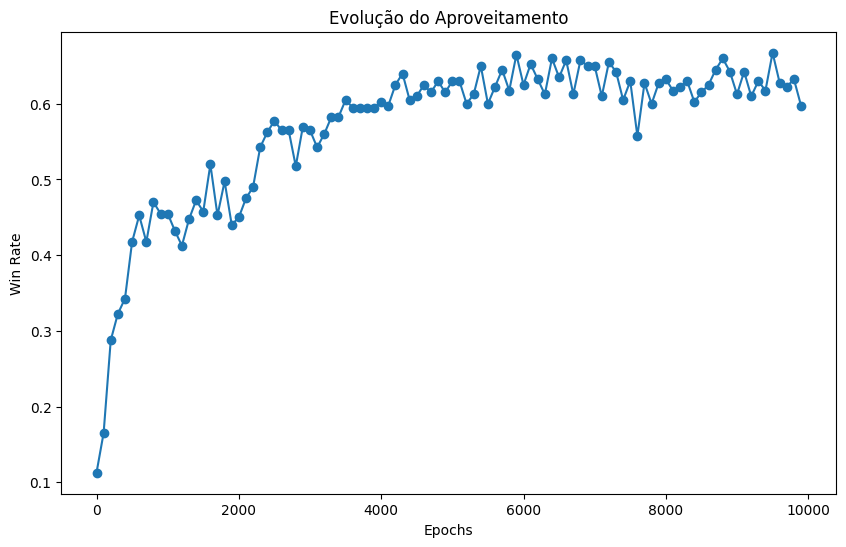

In [111]:
values_O, evolution_history = learn('O', 0.3, 0.3, 10000)

plot_evolution(evolution_history)

Epoch: 0
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000
Epoch: 6000
Epoch: 7000
Epoch: 8000
Epoch: 9000


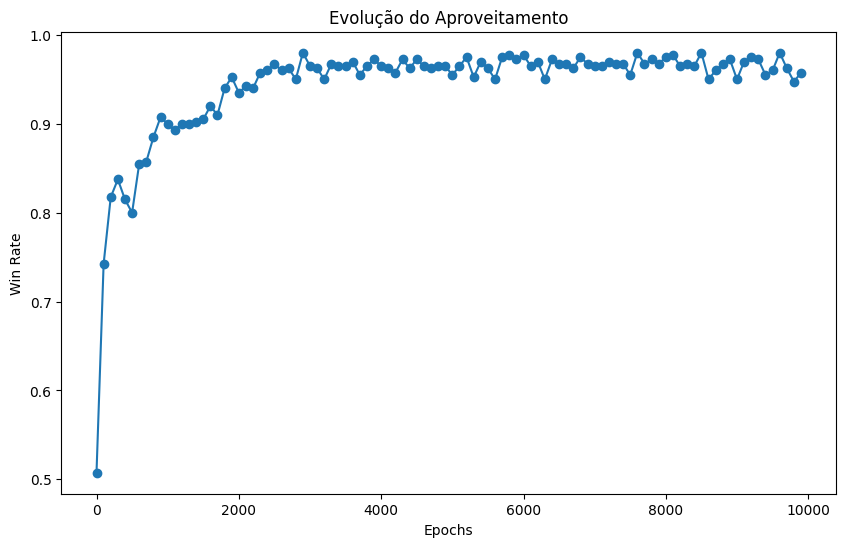

In [112]:
values_X, evolution_history = learn('X', 0.3, 0.3, 10000)

plot_evolution(evolution_history)

And so, we can play it out against our agent in ```tic-tac-toe.py```.